# Mixture Models using PyMC

Generated 5000 samples using parameters [5. 1.]


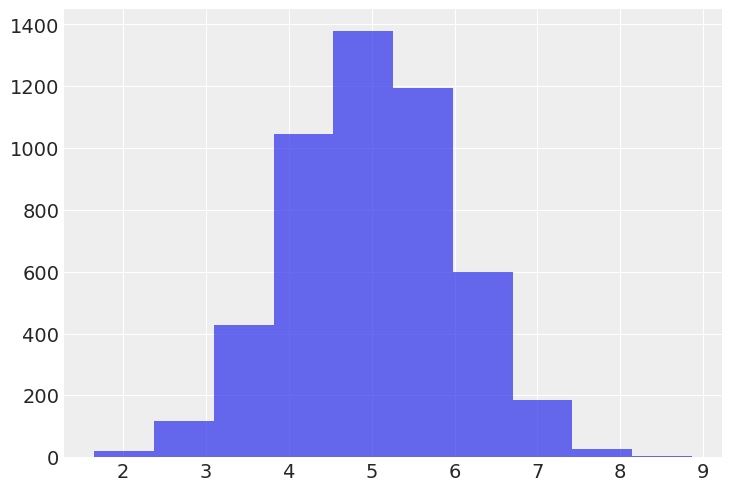

In [31]:
# Create a simple example

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 5000)
#curv.generate_background(xrange, 10.0)

measured = curv.data

#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)


In [32]:
import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal("mu", mu=4, sigma=3)
    sigma = pm.HalfNormal("sigma", sigma=2)
        
    like = pm.Normal("like", mu=mu, sigma=sigma, observed=measured)

# MAP model is "maximum a posteriori", i.e. find the peak in the
# posterior likelihood like you do for MLE.
map_estimate=pm.find_MAP(model=model)
map_estimate

# That is equivalent what EMTK is doing, so far so good.

{'mu': array(5.00643571),
 'sigma_log__': array(-0.00778952),
 'sigma': array(0.99224074)}

## With Background

Generated 2000 samples using parameters [5. 1.]


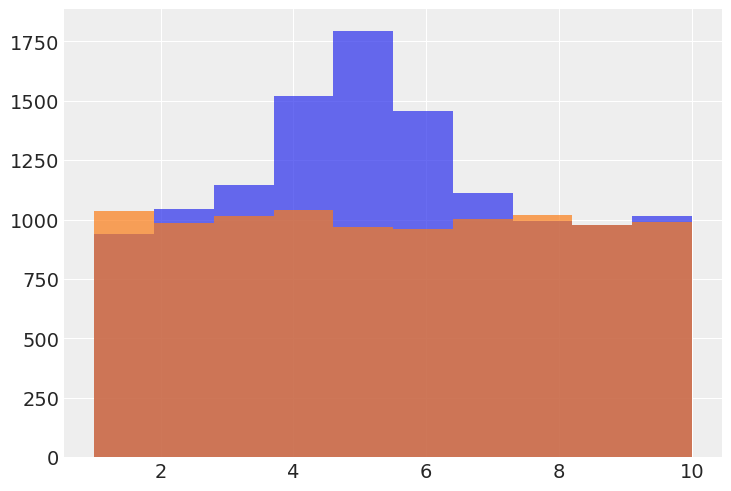

In [36]:
# Create sample measurement and background measurement

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 2000)
#curv.generate_background(xrange, 10.0)

sample_bg = np.random.uniform(xrange[0], xrange[1], 10000)
measured_bg = np.random.uniform(xrange[0], xrange[1], 10000)

measured = curv.data
measured = np.append(measured, sample_bg)
np.random.shuffle(measured)


#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)
bb=ax.hist(measured_bg, alpha=0.7)#, density=True)
xgrid = np.arange(2, 8, 0.5)
#xgrid = hh[1]
xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)


In [38]:
# Now we do the mixture model

import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # mixture model weights
    w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
    # Dirichlet distribution is a multivariate beta distribution,
    # C.F. simple bayesian inference with a beta distribution
    
    # Priors for unknown gaussian model parameters
    mu_par = pm.Normal("mu", mu=4, sigma=3)
    sigma_par = pm.HalfNormal("sigma", sigma=2)
    
    # Components in overall model - simple version
    components = [
        pm.Normal.dist(mu=mu_par, sigma=sigma_par),
        pm.Uniform.dist(lower=xrange[0], upper=xrange[1]),
    ]
    
    like = pm.Mixture("like", w=w, comp_dists = components, observed=measured)

map_estimate=pm.find_MAP(model=model)
map_estimate
                    

{'weights_simplex__': array([-0.78516544]),
 'mu': array(4.95992363),
 'sigma_log__': array(-0.08902149),
 'weights': array([0.17216923, 0.82783077]),
 'sigma': array(0.91482592)}

**BINGO**